<a href="https://colab.research.google.com/github/arpanmajhi/collab/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import yfinance as yf

# Get list of S&P 500 tickers
URL = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tickers = pd.read_html(URL)[0]['Symbol'].tolist()

In [2]:

# Download historical stock prices for all tickers
data = yf.download(tickers, period='3y')['Adj Close']

[*********************100%***********************]  503 of 503 completed

ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')
ERROR:yfinance:['LOW']: Exception("The following 'Dividends' events are out-of-range, did not expect with interval 1d: DatetimeIndex(['2020-07-21 00:00:00-04:00', '2020-10-20 00:00:00-04:00',\n               '2021-01-19 00:00:00-05:00', '2021-04-20 00:00:00-04:00',\n               '2021-07-20 00:00:00-04:00', '2021-10-19 00:00:00-04:00',\n               '2022-01-18 00:00:00-05:00', '2022-04-19 00:00:00-04:00',\n               '2022-07-19 00:00:00-04:00', '2022-10-18 00:00:00-04:00',\n               '2023-01-24 00:00:00-05:00', '2023-04-25 00:00:00-04:00'],\n              dtype='datetime64[ns, America/New_York]', freq=None)")
ERROR:yfinance:['APA']: Exception("The following 'Dividends' events are out-of-range, did not expect with interval 1d: DatetimeIndex(['2020-07-21 00:00:00-04:00', '2020-10-21 00:00:00-04:00',\n               '2021-01-21 00:00:00-05:00', '2021-0

In [3]:
data.to_csv('data.csv')

In [4]:
price_data = pd.read_csv('data.csv',index_col=0, parse_dates=True)

In [5]:
price_data.tail(2)

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2023-07-20,124.550003,17.440001,70.010002,193.130005,142.190002,193.410004,111.830002,81.500000,312.470001,516.880005,...,106.190002,64.559998,103.410004,40.590000,113.550003,135.880005,142.729996,304.540009,37.900002,171.610001
2023-07-21,127.620003,17.420000,70.730003,191.940002,143.740005,192.589996,114.290001,82.269997,314.799988,520.229980,...,107.180000,65.209999,103.889999,40.759998,113.769997,137.539993,142.229996,306.459991,36.110001,183.509995


In [6]:
lookback_start ='2021-01-01'
lookback_end = '2021-12-31'
lookahead_start = '2022-01-01'
lookahead_end = '2022-12-31'

In [7]:
returns= price_data.loc[lookback_start:lookback_end].pct_change()

In [8]:
import numpy as np
volatility= returns.std()
volatility = volatility* np.sqrt(252)*100

In [9]:
top_decile = volatility.nlargest(int(len(volatility)*0.1))

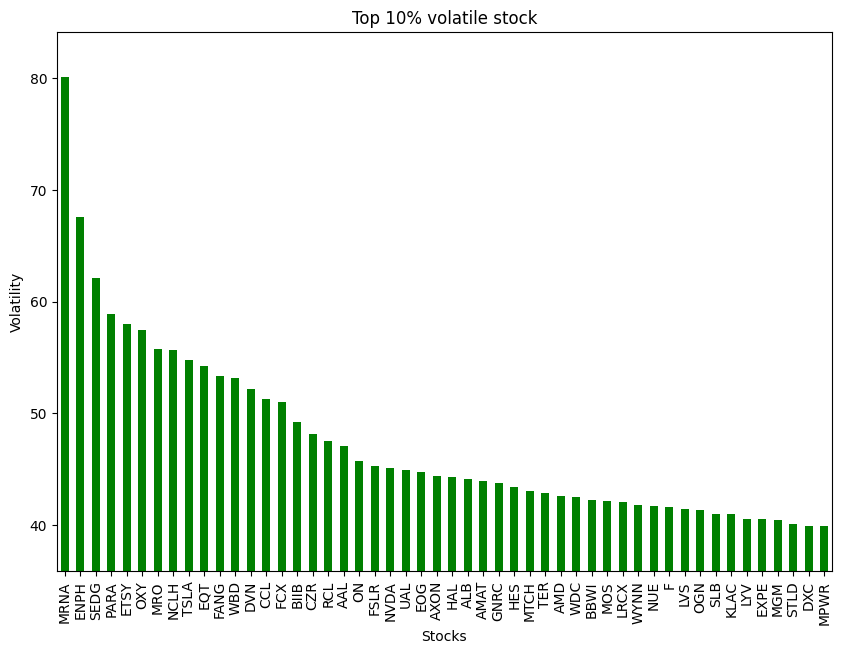

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
top_decile.plot.bar(figsize=(10,7),color= 'green',ylim=(top_decile.min()*0.9))
plt.title('Top 10% volatile stock')
plt.xlabel('Stocks')
plt.ylabel('Volatility')
plt.show()

In [11]:
portfolio = pd.DataFrame()
#folio = price_data.loc[lookahead_start:lookahead_end, top_decile.index]
portfolio['returns'] = price_data.loc[lookahead_start:lookahead_end, top_decile.index].pct_change().mean(axis=1)
portfolio['value'] = (portfolio+1).cumprod()
portfolio = portfolio.dropna()

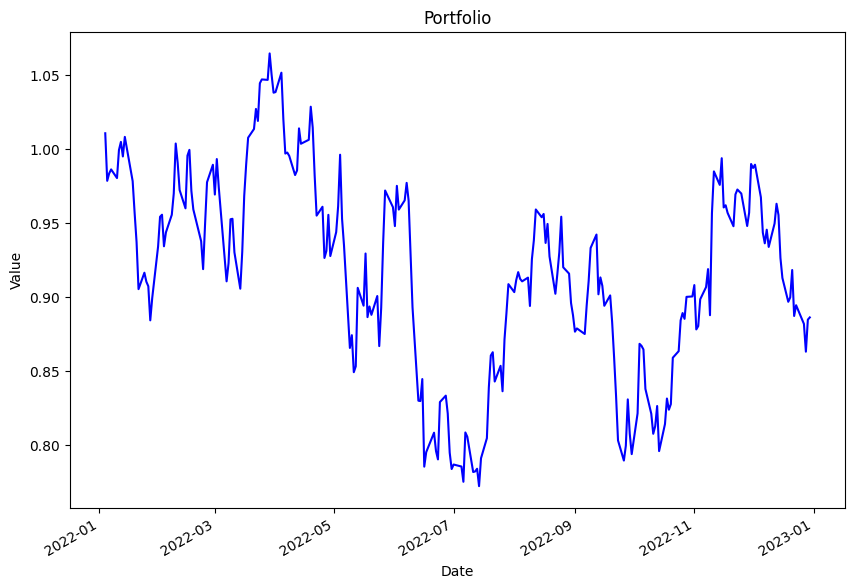

In [12]:
portfolio.value.plot(figsize=(10,7), color='b')
plt.title('Portfolio')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

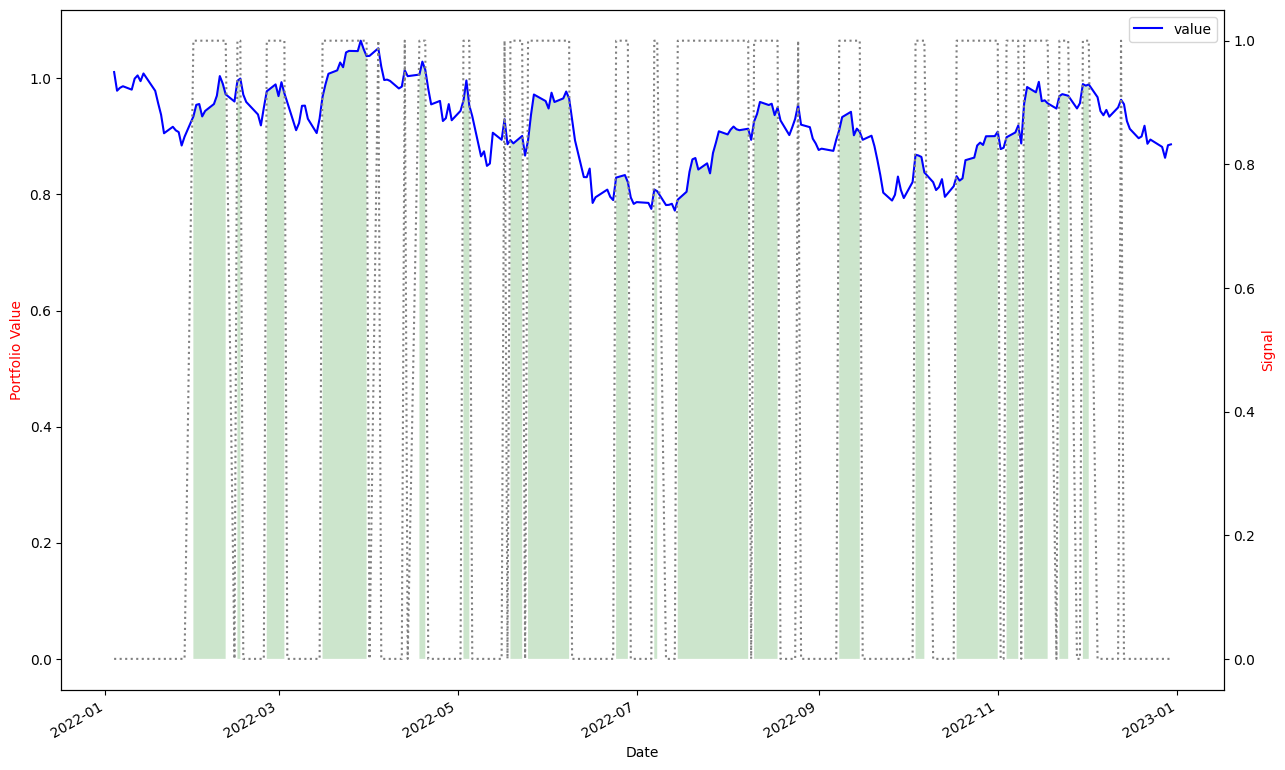

In [13]:
# Technical indicator
def get_strategy_returns_sma(portfolio):
    portfolio['sma10']= portfolio.value.rolling(window=10).mean()
    portfolio['signal'] = np.where(portfolio.value>portfolio.sma10,1,0)
    portfolio['str_returns'] = portfolio.signal * portfolio.returns.shift(-1)
    return(portfolio)

def plot_signal(portfolio):
    portfolio['value'].plot(color='blue')
    plt.fill_between(portfolio.index, portfolio.value, where=(portfolio.signal==1), facecolor='g', alpha=0.2)
    plt.legend()
    plt.ylabel('Portfolio Value',color='r')
    # Plot the signal values
    portfolio['signal'].plot(secondary_y=True,figsize=(15,10),color='grey', linestyle='dotted')
    plt.ylabel('Signal',color='r')
    plt.show()

portfolio = get_strategy_returns_sma(portfolio)
plot_signal(portfolio)

The Sharpe ratio is -0.60 


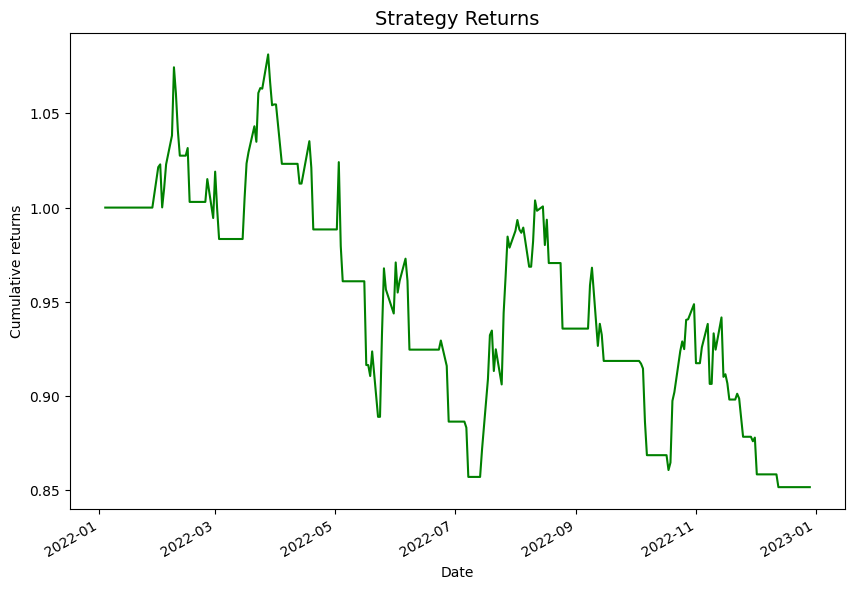

The maximum drawdown is -21.25


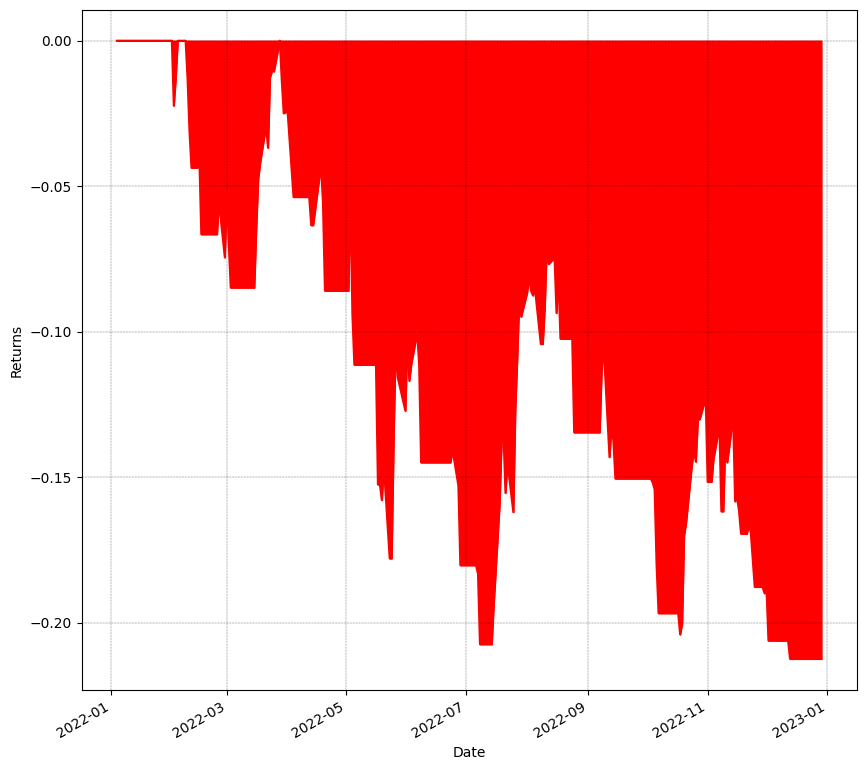

In [14]:
# Plot the portfolio returns
def plot_returns_dd(portfolio):
    # ----------- Sharpe ratio ------------------
    sharpe_ratio = np.mean(portfolio.str_returns)/np.std(portfolio.str_returns)*(252**0.5)
    print('The Sharpe ratio is %.2f ' % sharpe_ratio)

    # ----------- Cumulative strategy returns ------------------
    portfolio['cum_str_returns'] = (portfolio['str_returns']+1).cumprod()
    # Plot the cumulative strategy returns
    portfolio['cum_str_returns'].plot(figsize=(10,7), color='green')
    plt.title('Strategy Returns', fontsize=14)
    plt.ylabel('Cumulative returns')
    plt.show()

    # ----------- Drawdown ------------------
    # Calculate the running maximum
    running_max = np.maximum.accumulate(portfolio['cum_str_returns'].dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (portfolio['cum_str_returns'])/running_max - 1
    max_dd = drawdown.min()*100
    print('The maximum drawdown is %.2f' % max_dd)
    # Plot the drawdowns
    drawdown.plot(color='r',figsize=(10,10))
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()

plot_returns_dd(portfolio)

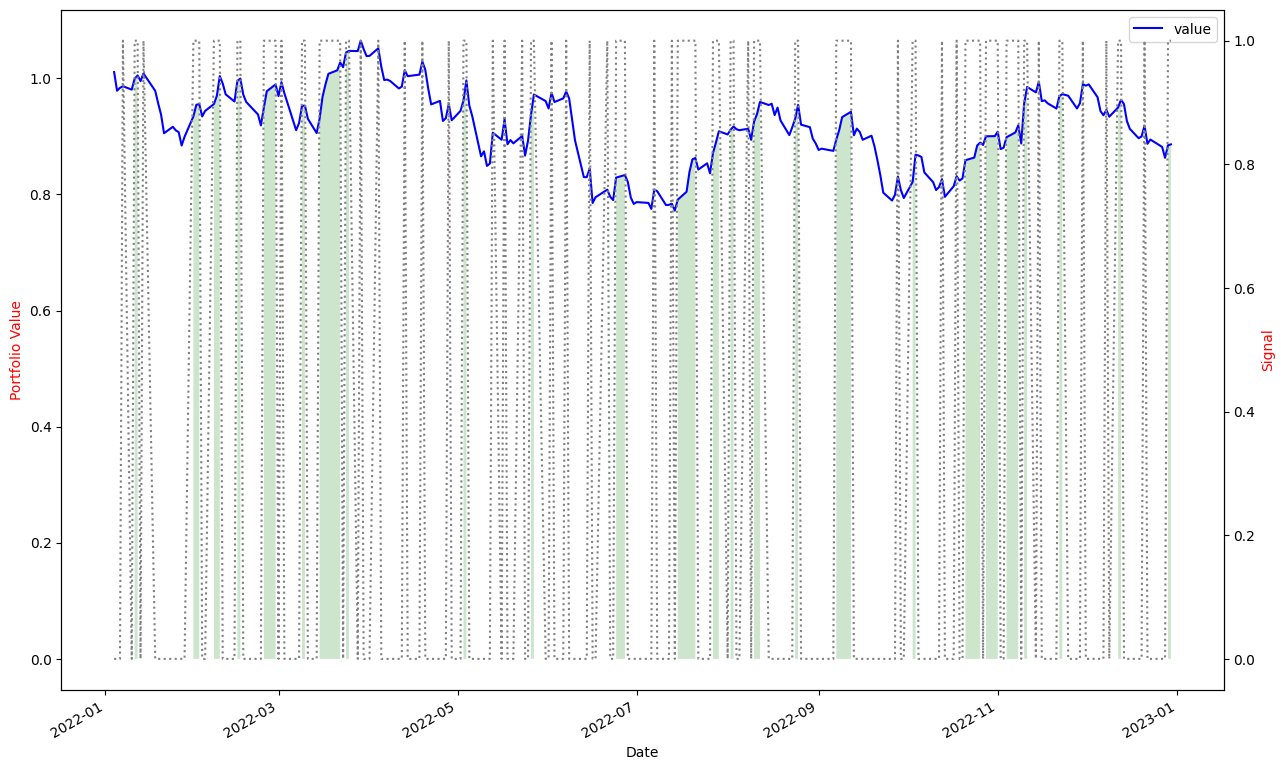

The Sharpe ratio is -1.07 


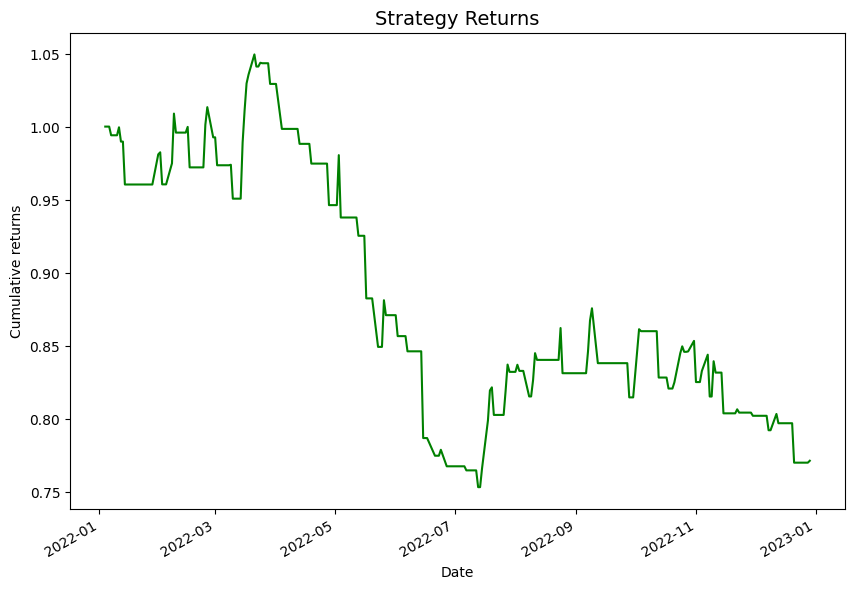

The maximum drawdown is -28.22


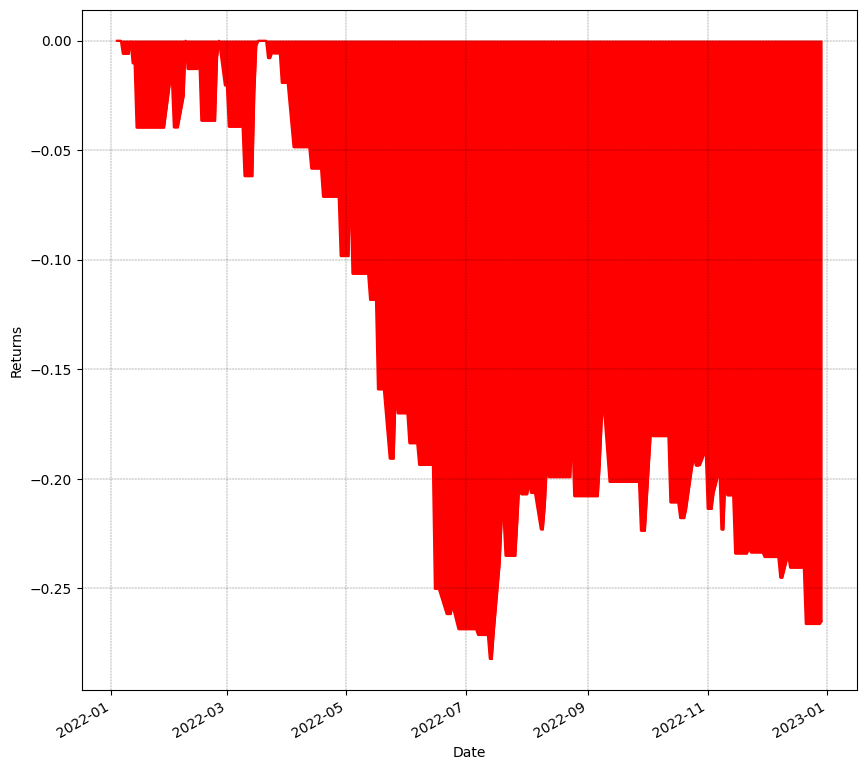

In [15]:
def get_strategy_returns_breakout(portfolio):
    portfolio['high'] = portfolio.value.rolling(window=3).max()
    portfolio['signal'] = np.where(portfolio.value>=portfolio.high,1,0)
    portfolio['str_returns'] = portfolio.returns.shift(-1)*portfolio.signal
    return(portfolio)

portfolio = get_strategy_returns_breakout(portfolio)
plot_signal(portfolio)
plot_returns_dd(portfolio)

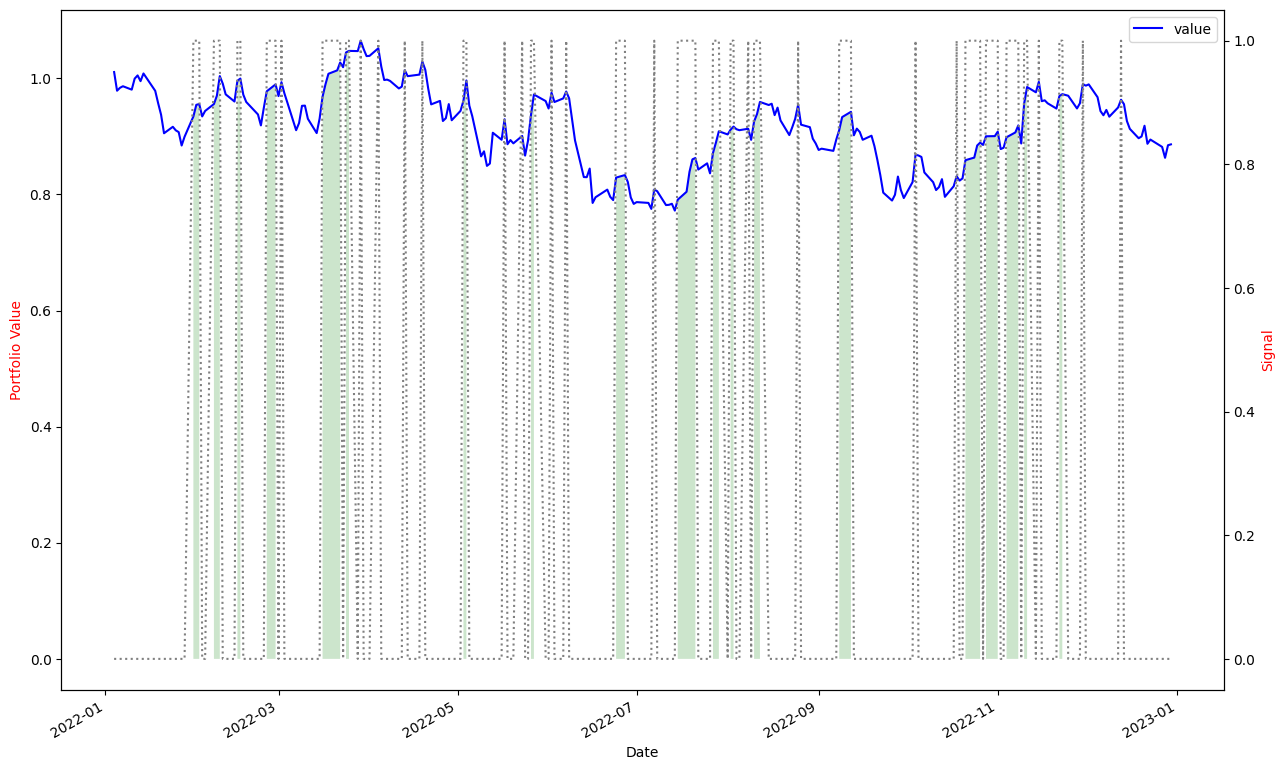

The Sharpe ratio is -0.61 


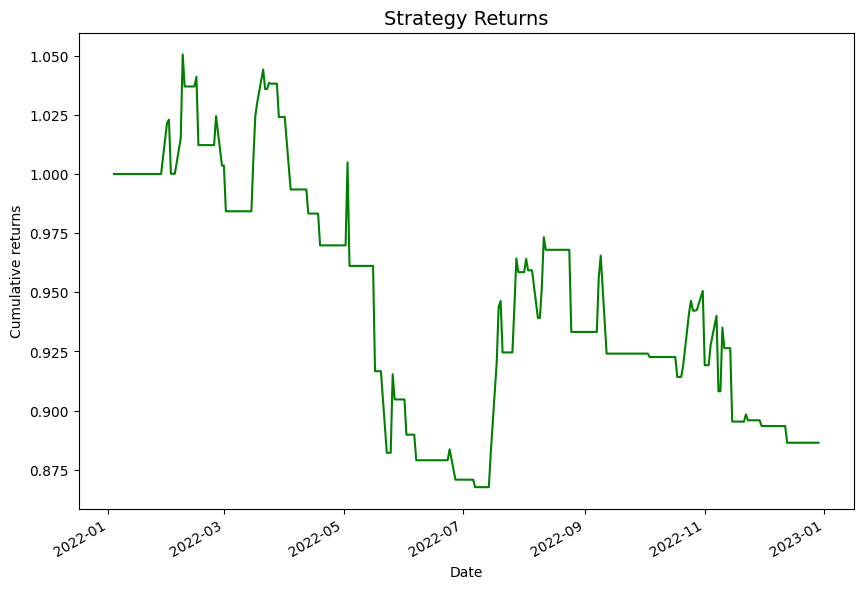

The maximum drawdown is -17.41


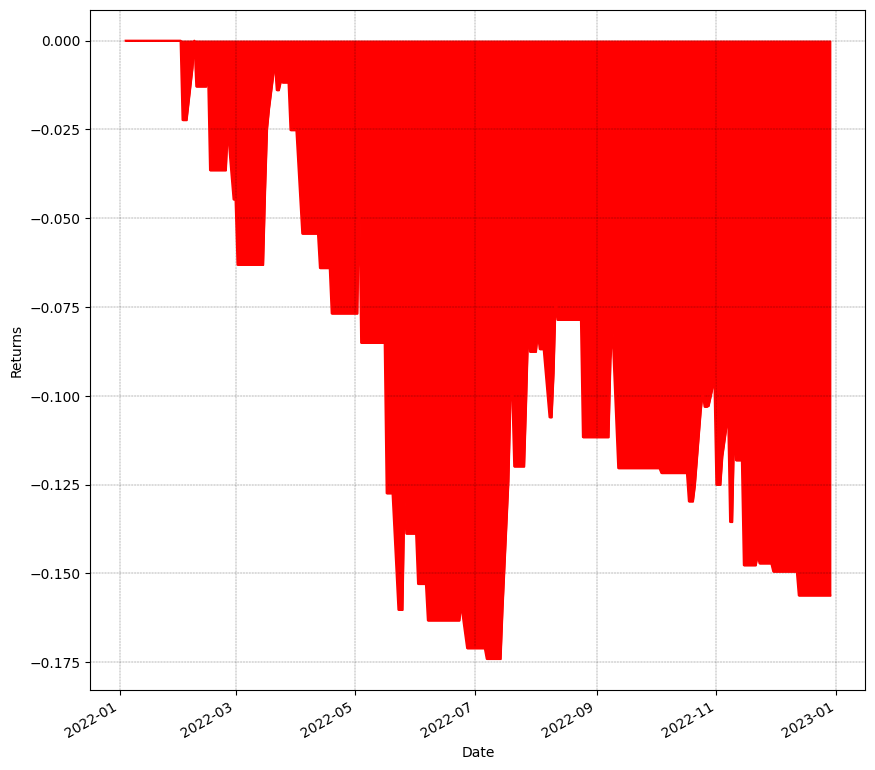

In [16]:
def get_strategy_returns_sma_breakout(portfolio):
    sma10 = portfolio.value>portfolio.value.rolling(window=10).mean()
    breakout = portfolio.value>= portfolio.value.rolling(window=3).max()

    # Siganl
    portfolio['signal'] = np.where(sma10 & breakout,1,0)
    portfolio['str_returns'] = portfolio.returns.shift(-1)*portfolio.signal
    return(portfolio)

portfolio = get_strategy_returns_sma_breakout(portfolio)
plot_signal(portfolio)
plot_returns_dd(portfolio)

In [17]:
portfolio.tail()

,returns,value,sma10,signal,str_returns,cum_str_returns,high
Date,,,,,,,
2022-12-23,0.008199,0.894503,0.920447,0,-0.0,0.886429,0.918317
2022-12-27,-0.014130,0.881864,0.913658,0,-0.0,0.886429,0.894503
2022-12-28,-0.021306,0.863075,0.903653,0,0.0,0.886429,0.894503
2022-12-29,0.025111,0.884748,0.896578,0,0.0,0.886429,0.884748
2022-12-30,0.001702,0.886254,0.892556,0,NaN,NaN,0.886254
